In [1]:
import xarray as xr
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import matplotlib
import datetime
import pickle
import pandas as pd
import itertools
from scipy.stats import linregress
import seaborn as sns
sns.set('paper')
from scipy.stats import t
from statsmodels.tsa.stattools import acf



This notebook examines the ignificance of trends in the fraction of extreems. In addition to using the effective sample size, we also use block bootstrapping to test for significance. 

In [2]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$\mathrm{O}_2$",
    OmegaA="$\Omega_A$",
    T="T"
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)
color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [3]:
def print_h(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m")
print_h('text', 43)

text


To adjust for autocorrelation, we will use the method of Bretherton et al 1999. 

## Single stressor extremes in the Canyons

us the pickles created for the correlation analysis as they are not separated by upw/dwn. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def block_bootstrap_trend_with_visualization(values, dates, block_size=365, n_iterations=5000, ci_percentile=95):
    """
    Perform block bootstrapping to estimate trends, calculate a bootstrap-based p-value,
    visualize the results, and return the confidence interval of the bootstrap slopes.

    Parameters:
        values (np.ndarray): Array of daily data values.
        dates (np.ndarray): Array of dates corresponding to the values (in datetime64 format).
        block_size (int): Approximate size of blocks in days (default is 365 for yearly blocks).
        n_iterations (int): Number of bootstrap iterations.
        ci_percentile (float): Percentile for confidence interval (default is 95).

    Returns:
        original_slope (float): Slope calculated from the original data in units of years.
        bootstrap_slopes (list): List of slope values from bootstrap samples in units of years.
        bootstrap_p_value (float): Bootstrap-based p-value.
        ci_lower (float): Lower bound of the confidence interval.
        ci_upper (float): Upper bound of the confidence interval.
    """
    if len(values) != len(dates):
        raise ValueError("The values and dates arrays must have the same length.")
    
    # Convert dates to timestamps (seconds since the epoch)
    dates_timestamp = np.array([x.astype('datetime64[s]').astype('int') for x in dates])
    
    # Calculate the original slope (in units per second)
    x_original = np.arange(len(values))
    original_slope, _, _, _, _ = linregress(dates_timestamp, values)
    
    # Convert the original slope to years (seconds per year)
    seconds_per_year = 365.25 * 24 * 60 * 60  # accounting for leap years roughly
    original_slope_years = original_slope * seconds_per_year
    
    years = np.unique(dates.astype("datetime64[Y]"))
    bootstrap_slopes = []
    
    for _ in range(n_iterations):
        # Sampling years with replacement
        sampled_years = np.random.choice(years, size=len(years), replace=True)
        sampled_indices = np.isin(dates.astype("datetime64[Y]"), sampled_years)
        bootstrap_sample = values[sampled_indices]
        bootstrap_dates_timestamp = dates_timestamp[sampled_indices]
        
        slope, _, _, _, _ = linregress(bootstrap_dates_timestamp, bootstrap_sample)
        
        # Convert the bootstrap slope to years (seconds per year)
        bootstrap_slope_years = slope * seconds_per_year
        bootstrap_slopes.append(bootstrap_slope_years)
    
    # Calculate one-sided bootstrap p-value
    if original_slope_years > 0:
        # Positive slope: p-value is proportion of bootstrap slopes >= original slope
        bootstrap_p_value = np.mean(np.array(bootstrap_slopes) >= original_slope_years)
        extreme_slopes = np.array(bootstrap_slopes) >= original_slope_years
    else:
        # Negative slope: p-value is proportion of bootstrap slopes <= original slope
        bootstrap_p_value = np.mean(np.array(bootstrap_slopes) <= original_slope_years)
        extreme_slopes = np.array(bootstrap_slopes) <= original_slope_years
    
    # Calculate the confidence interval (e.g., 95% CI)
    ci_lower = np.percentile(bootstrap_slopes, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(bootstrap_slopes, 100 - (100 - ci_percentile) / 2)
    
    # Visualization
    plt.figure(figsize=(5,4))
    
    # Histogram of bootstrap slopes
    plt.hist(bootstrap_slopes, bins=30, alpha=0.7, color='skyblue', label="Bootstrap Slopes")
    
    # Original slope as vertical line
    plt.axvline(original_slope_years, color='red', linestyle='--', linewidth=2, label=f"Original Slope = {original_slope_years:.5f} units/year")
    
    # Shading extreme regions
    plt.hist(np.array(bootstrap_slopes)[extreme_slopes], bins=30, alpha=0.4, color='orange', label="Extreme Slopes")
    
    # Confidence interval lines
    plt.axvline(ci_lower, color='green', linestyle='-.', linewidth=2, label=f"{ci_percentile}% CI Lower = {ci_lower:.5f} units/year")
    plt.axvline(ci_upper, color='green', linestyle='-.', linewidth=2, label=f"{ci_percentile}% CI Upper = {ci_upper:.5f} units/year")
    
    # Labels and legend
    plt.title(f"Bootstrap Slope Distribution (p-value: {bootstrap_p_value:.5f})", fontsize=14)
    plt.xlabel("Slope (units/year)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(ci_lower,ci_upper)
    return original_slope_years, bootstrap_slopes, bootstrap_p_value, ci_lower, ci_upper




In [5]:
# Example placeholders for clusters, variables, and data
clusters = [f"Cluster_{i}" for i in range(1, 7)]  # 6 clusters
variables = ['O2', 'T', 'OmegaA','OmegaA'+'T', 'OmegaA'+'O2', 'T'+'O2', 'T'+'O2'+'OmegaA' ]  # 7 variables

In [6]:
def get_results(cluster, results):
    
    for idx, var in enumerate(timeseries_vars):
        print(var)
        print('##################################')
        #ax = fig.add_subplot(3,1,idx+1)
        #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
        for ii,label in enumerate(['Upwelling', 'Downwelling']):
            name0='pickles/'+label+'_'+cluster+'_'+var +'_corr.pickle'
            print(name0)
            with open(name0, 'rb') as fid:
                df = pickle.load(fid)
                df.name=var

            #print(df)
            #ax.scatter(df.time, df, label=label, s=2)
            if ii==0:
                upw=df
                
            else:
                dwn=df
        merged_da = xr.merge([dwn,upw])
        #print(merged_da, type(merged_da))
        X=merged_da.time.values
        Y=merged_da[var].values
        #slopes,p_values = block_bootstrap_trend_numpy(Y, X, n_iterations=1000)
        slope, bs_slopes,p_value, ci_lower,ci_upper = block_bootstrap_trend_with_visualization(
        Y, X, n_iterations=5000
    )    
        if ci_lower*ci_upper>0:
            print(' The trend for  ', var, 'is significant according to moving bootstrapping')
        results.append({
                "Cluster": cluster,
                "Variable": var,
                "Slope": slope,
                "P-Value": p_value,
                "CI Lower": ci_lower,
                "CI Upper": ci_upper,
                "sig": ci_lower*ci_upper>0, })
    return results


The moving block and block bootstrapping m,ethods perform similarly. The Davis approach may not be appropriuate here as there is an assumption of stationarity. 

O2
##################################
pickles/Upwelling_0_O2_corr.pickle
pickles/Downwelling_0_O2_corr.pickle


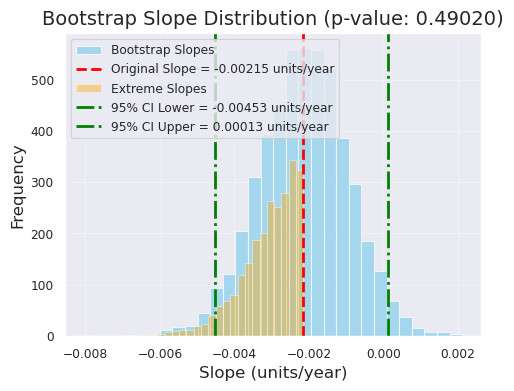

-0.004527617640558045 0.00013112918900457323
OmegaA
##################################
pickles/Upwelling_0_OmegaA_corr.pickle
pickles/Downwelling_0_OmegaA_corr.pickle


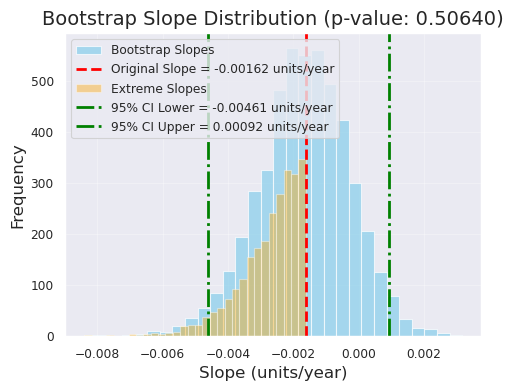

-0.004606861515527143 0.0009222039889315672
T
##################################
pickles/Upwelling_0_T_corr.pickle
pickles/Downwelling_0_T_corr.pickle


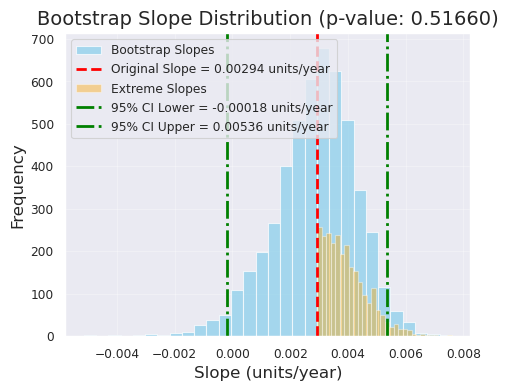

-0.00017789582459633923 0.005359655573164187


In [7]:
results=[]
results=get_results('0', results)

### Single stressor trends for the shallows

O2
##################################
pickles/Upwelling_3_O2_corr.pickle
pickles/Downwelling_3_O2_corr.pickle


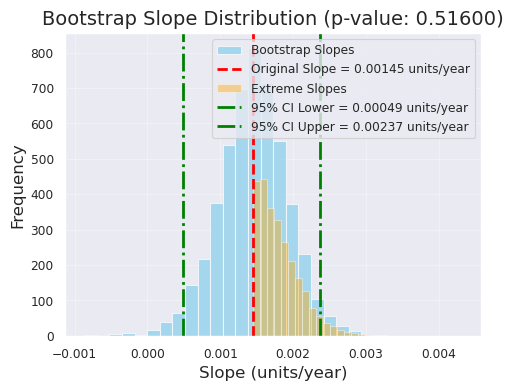

0.0004892859841007023 0.0023736035390153386
 The trend for   O2 is significant according to moving bootstrapping
OmegaA
##################################
pickles/Upwelling_3_OmegaA_corr.pickle
pickles/Downwelling_3_OmegaA_corr.pickle


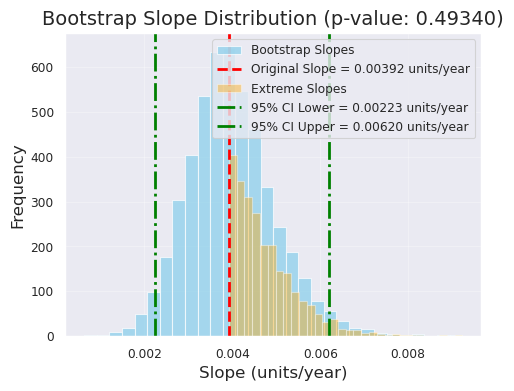

0.002229947331851621 0.006204168337313894
 The trend for   OmegaA is significant according to moving bootstrapping
T
##################################
pickles/Upwelling_3_T_corr.pickle
pickles/Downwelling_3_T_corr.pickle


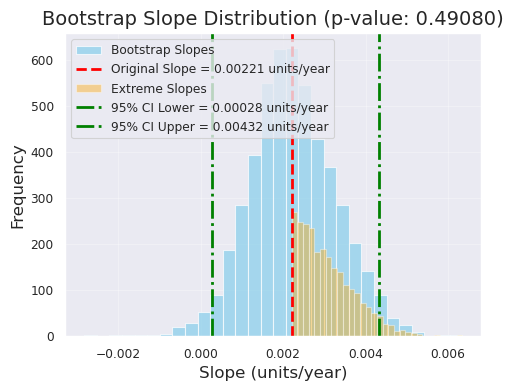

0.00028104619720019174 0.004317333016714176
 The trend for   T is significant according to moving bootstrapping


In [8]:
results=get_results('3', results)

O2
##################################
pickles/Upwelling_1_O2_corr.pickle
pickles/Downwelling_1_O2_corr.pickle


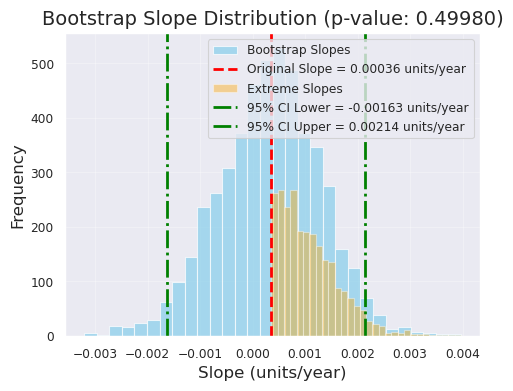

-0.0016280670421301028 0.002139833085796183
OmegaA
##################################
pickles/Upwelling_1_OmegaA_corr.pickle
pickles/Downwelling_1_OmegaA_corr.pickle


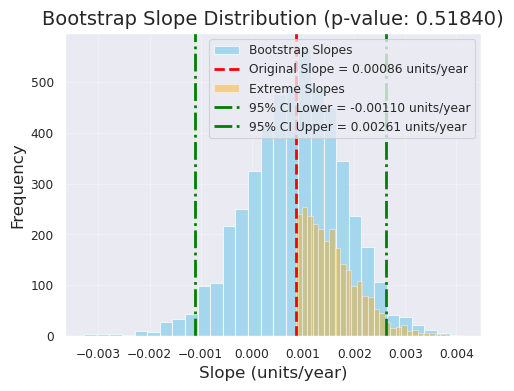

-0.0011043035363076403 0.002612763837029204
T
##################################
pickles/Upwelling_1_T_corr.pickle
pickles/Downwelling_1_T_corr.pickle


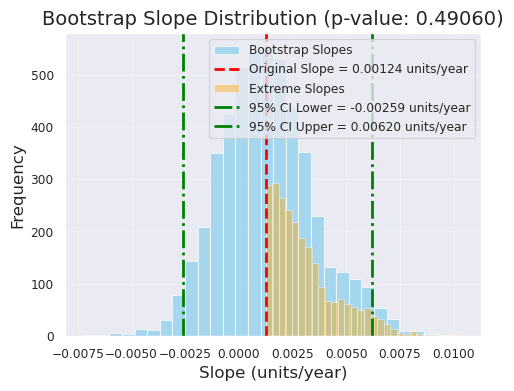

-0.00259254917389307 0.006203377557569596
--------------- cluster 2 -------
O2
##################################
pickles/Upwelling_2_O2_corr.pickle
pickles/Downwelling_2_O2_corr.pickle


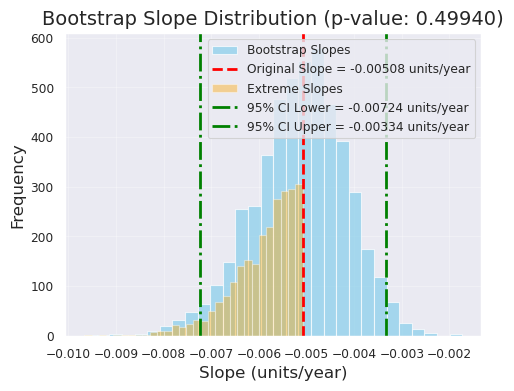

-0.007236949708093191 -0.003340055995427419
 The trend for   O2 is significant according to moving bootstrapping
OmegaA
##################################
pickles/Upwelling_2_OmegaA_corr.pickle
pickles/Downwelling_2_OmegaA_corr.pickle


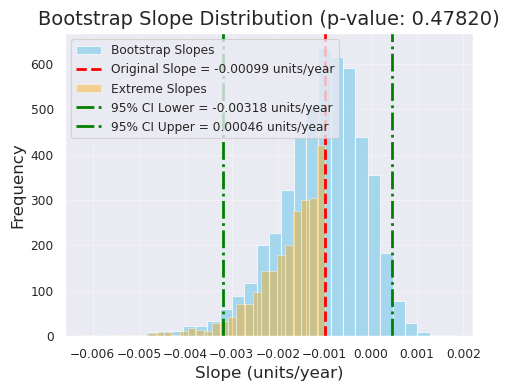

-0.0031835707834150465 0.00045855698623501346
T
##################################
pickles/Upwelling_2_T_corr.pickle
pickles/Downwelling_2_T_corr.pickle


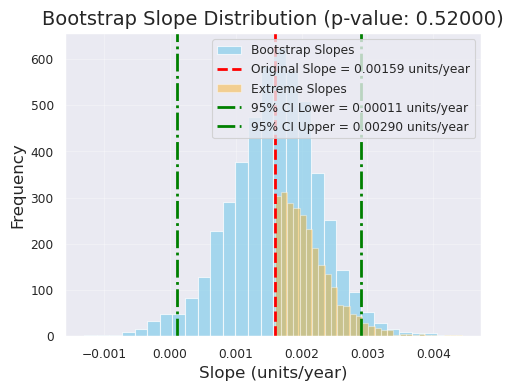

0.00011447310242369451 0.0029015041698425203
 The trend for   T is significant according to moving bootstrapping
--------------- cluster 4 -------
O2
##################################
pickles/Upwelling_4_O2_corr.pickle
pickles/Downwelling_4_O2_corr.pickle


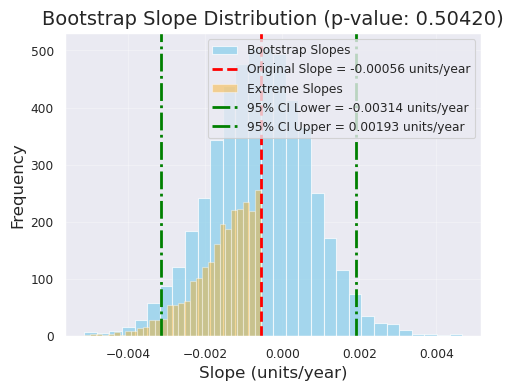

-0.0031397141501855346 0.0019267888964062774
OmegaA
##################################
pickles/Upwelling_4_OmegaA_corr.pickle
pickles/Downwelling_4_OmegaA_corr.pickle


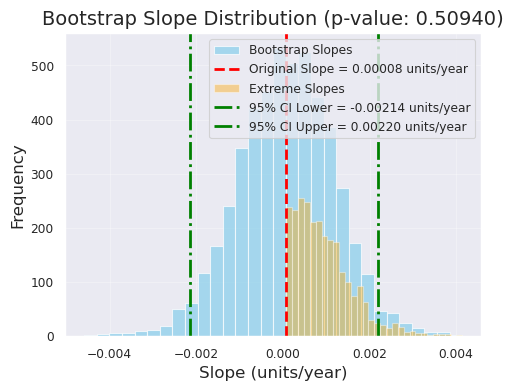

-0.002136097036953043 0.0022037183901134857
T
##################################
pickles/Upwelling_4_T_corr.pickle
pickles/Downwelling_4_T_corr.pickle


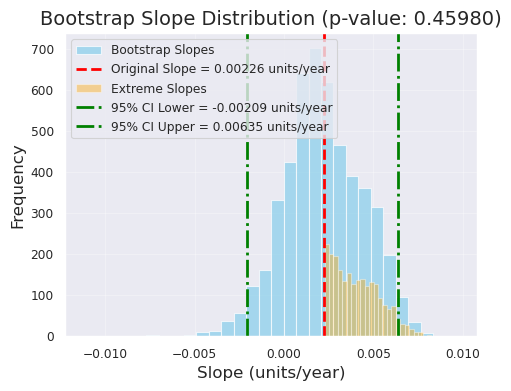

-0.002092810424936449 0.006354622083253635
--------------- cluster 5 -------
O2
##################################
pickles/Upwelling_5_O2_corr.pickle
pickles/Downwelling_5_O2_corr.pickle


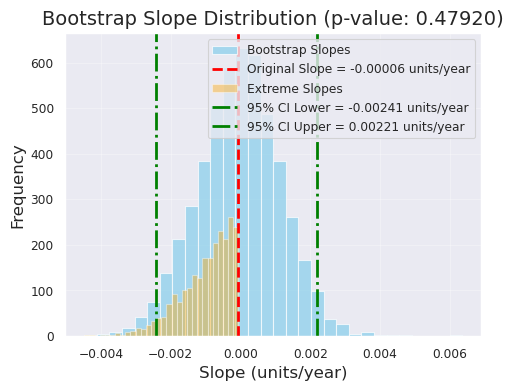

-0.0024141846934841115 0.002205546285920675
OmegaA
##################################
pickles/Upwelling_5_OmegaA_corr.pickle
pickles/Downwelling_5_OmegaA_corr.pickle


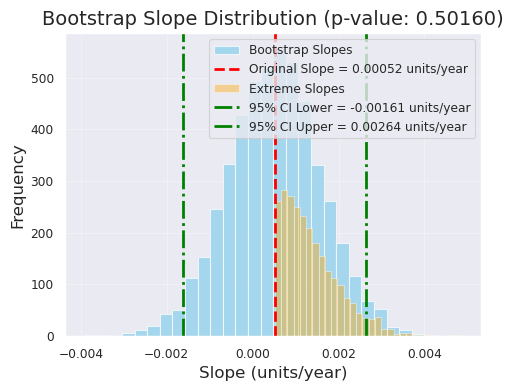

-0.0016125169815399286 0.0026428292720421655
T
##################################
pickles/Upwelling_5_T_corr.pickle
pickles/Downwelling_5_T_corr.pickle


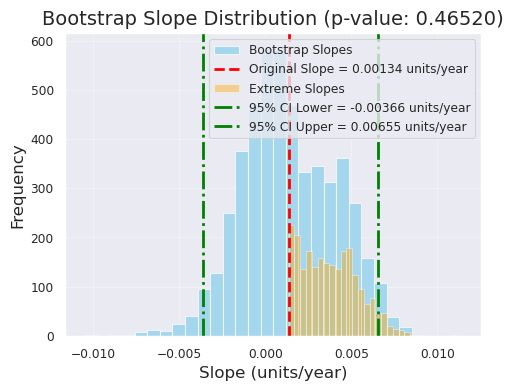

-0.003655851421480472 0.006545956735324926


In [9]:
results=get_results('1', results)
print('--------------- cluster 2 -------')
results=get_results('2', results)
print('--------------- cluster 4 -------')

results=get_results('4', results)
print('--------------- cluster 5 -------')

results=get_results('5', results)
# Convert results to DataFrame for easier filtering and analysis
results_df = pd.DataFrame(results)

# Filter significant results
significant_results = results_df[results_df["sig"]]


In [10]:
results_df

,Cluster,Variable,Slope,P-Value,CI Lower,CI Upper,sig
0,0,O2,-0.002150,0.4902,-0.004528,0.000131,False
1,0,OmegaA,-0.001620,0.5064,-0.004607,0.000922,False
2,0,T,0.002945,0.5166,-0.000178,0.005360,False
3,3,O2,0.001448,0.5160,0.000489,0.002374,True
4,3,OmegaA,0.003922,0.4934,0.002230,0.006204,True
5,3,T,0.002207,0.4908,0.000281,0.004317,True
6,1,O2,0.000358,0.4998,-0.001628,0.002140,False
7,1,OmegaA,0.000861,0.5184,-0.001104,0.002613,False
8,1,T,0.001243,0.4906,-0.002593,0.006203,False
9,2,O2,-0.005081,0.4994,-0.007237,-0.003340,True


## Compound event trends for the canyons

In [14]:
def get_results_compound(cluster_id, results, dual):
    
    print(dual_extreme[dual][0]+dual_extreme[dual][1])
    print('##################################')
    #ax = fig.add_subplot(3,1,idx+1)
    #fig, ax = plt.subplots(1,1, figsize = (Wf,Hf))
    for ii,label in enumerate(['Upwelling', 'Downwelling']):
        var=dual_extreme[dual]

        name0='pickles/'+label+'_'+str(cluster_id)+'_'+dual_extreme[dual][0]+dual_extreme[dual][1]+'_corr.pickle'
        #name0=label+'_0'+var +'.pickle'
        with open(name0, 'rb') as fid:
            df = pickle.load(fid)
            df.name=var

        color=colors[ii]
        if ii==0:
            upw=df.to_dataset(name='var', promote_attrs=True)   
        else:
            dwn=df.to_dataset(name='var', promote_attrs=True) 
    merged_da = xr.merge([dwn,upw])
    #print(merged_da.time, merged_da)
    X=merged_da.time.values
    Y=merged_da['var'].values
    #slopes,p_values = block_bootstrap_trend_numpy(Y, X, n_iterations=1000)
    slope, bs_slopes,p_value, ci_lower,ci_upper = block_bootstrap_trend_with_visualization(
    Y, X, n_iterations=5000
)
    
    if ci_lower*ci_upper>0:
        print(' The trend for  ', var, 'is significant according to moving bootstrapping')
    results.append({
            "Cluster": cluster_id,
            "Variable": dual_extreme[dual][0]+dual_extreme[dual][1],
            "Slope": slope,
            "P-Value": p_value,
            "CI Lower": ci_lower,
            "CI Upper": ci_upper,
            "sig": ci_lower*ci_upper>0, 
})
    return results


There is an apparent linear trend in some of the triple extremes. Here, I test for significance. 



In [15]:
at=0.01
bt=0.95
colors=[color1, color2]
dual_extreme = list(itertools.combinations(timeseries_vars, 2))
dual_extreme += [('T','O2','OmegaA')]
labelnames = [r'$\mathrm{O}_2$ and $\Omega_A$', r'$\mathrm{O}_2$ and T', r'$\Omega_A$ and T',r'T and $\mathrm{O}_2$ and $\Omega_A$']
dual_extreme[0]

('O2', 'OmegaA')

O2OmegaA
##################################


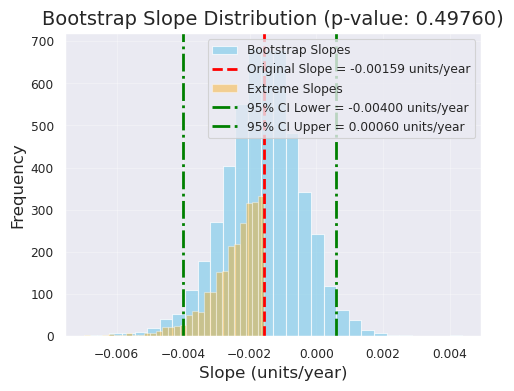

-0.003998879173791972 0.0005963003669274704


In [16]:
results=get_results_compound(0, results,0)

In [17]:
results_df = pd.DataFrame(results)


In [18]:
results_df

,Cluster,Variable,Slope,P-Value,CI Lower,CI Upper,sig
0,0,O2,-0.002150,0.4902,-0.004528,0.000131,False
1,0,OmegaA,-0.001620,0.5064,-0.004607,0.000922,False
2,0,T,0.002945,0.5166,-0.000178,0.005360,False
3,3,O2,0.001448,0.5160,0.000489,0.002374,True
4,3,OmegaA,0.003922,0.4934,0.002230,0.006204,True
5,3,T,0.002207,0.4908,0.000281,0.004317,True
6,1,O2,0.000358,0.4998,-0.001628,0.002140,False
7,1,OmegaA,0.000861,0.5184,-0.001104,0.002613,False
8,1,T,0.001243,0.4906,-0.002593,0.006203,False
9,2,O2,-0.005081,0.4994,-0.007237,-0.003340,True


O2OmegaA
##################################


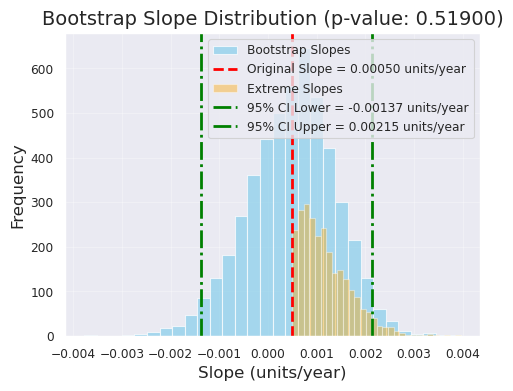

-0.0013715337064186875 0.0021468251083961746
O2OmegaA
##################################


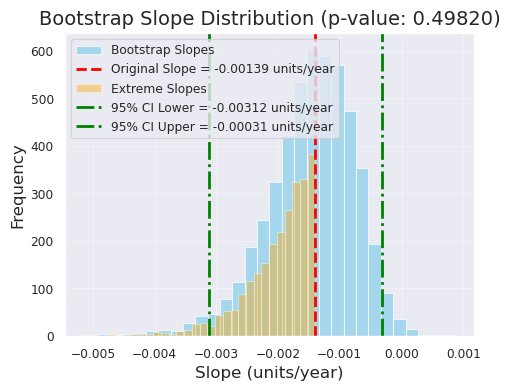

-0.003119670788819406 -0.0003106445307762177
 The trend for   ('O2', 'OmegaA') is significant according to moving bootstrapping
O2OmegaA
##################################


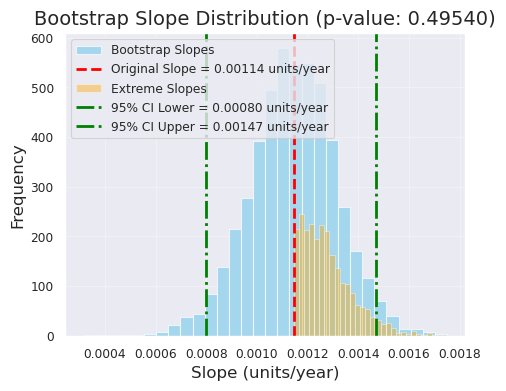

0.0007989242876754319 0.0014715657715478015
 The trend for   ('O2', 'OmegaA') is significant according to moving bootstrapping
O2OmegaA
##################################


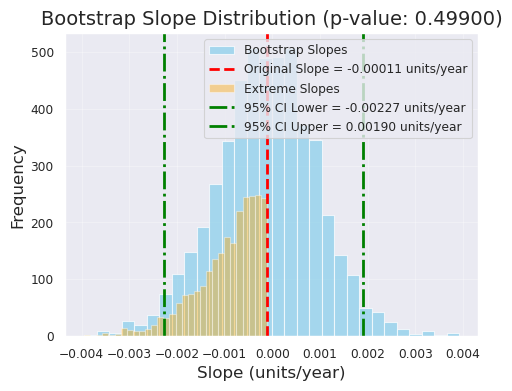

-0.002272538760820379 0.0019024771123660699
O2OmegaA
##################################


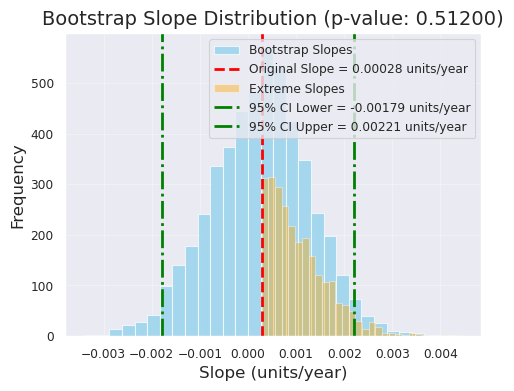

-0.0017870809447168283 0.002210230334445087


In [19]:
for cluster_id in np.arange(1,6):
    results=get_results_compound(cluster_id, results, 0)

O2T
##################################


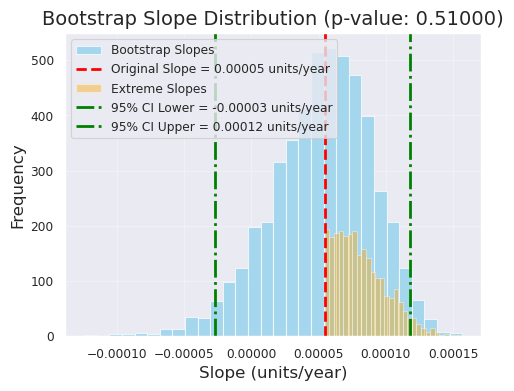

-2.6800867339566248e-05 0.00011793615956507227
O2T
##################################


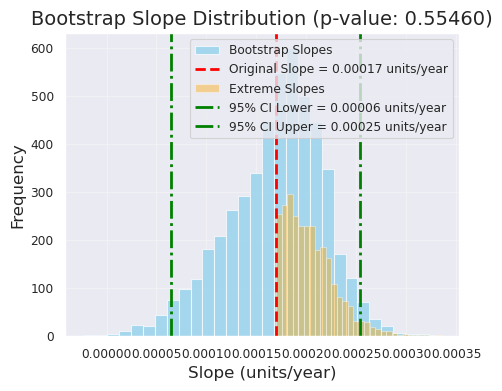

6.466483488812579e-05 0.00025420527196463335
 The trend for   ('O2', 'T') is significant according to moving bootstrapping
O2T
##################################


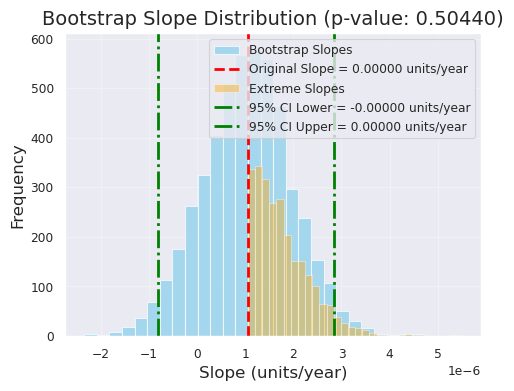

-8.137964883425357e-07 2.839256823010561e-06
O2T
##################################


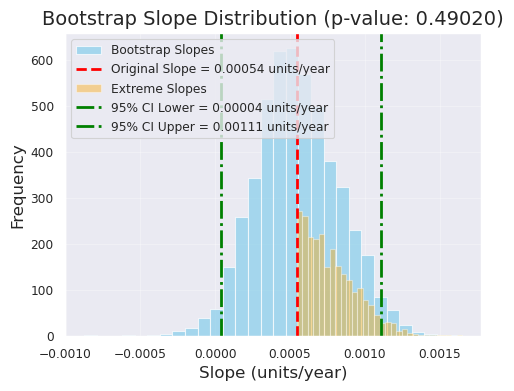

3.6432028353760745e-05 0.0011103834752132554
 The trend for   ('O2', 'T') is significant according to moving bootstrapping
O2T
##################################


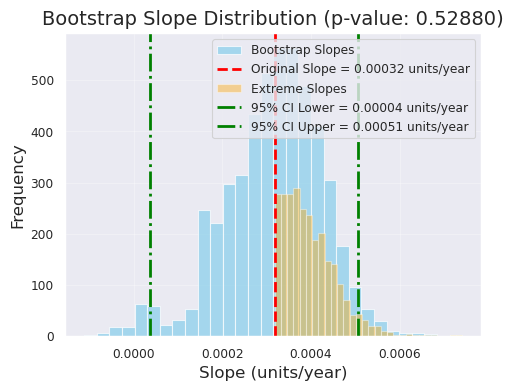

3.637768622926517e-05 0.0005063062930857991
 The trend for   ('O2', 'T') is significant according to moving bootstrapping
O2T
##################################


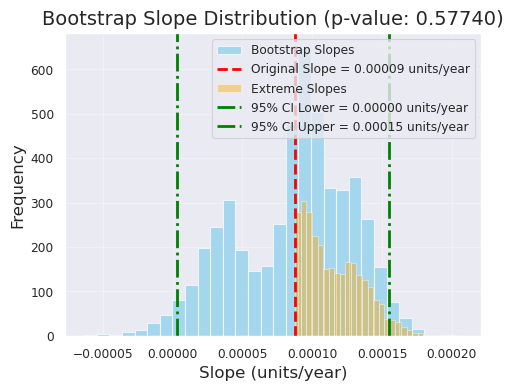

3.2551520644249466e-06 0.00015468920226829045
 The trend for   ('O2', 'T') is significant according to moving bootstrapping


In [20]:
for cluster_id in np.arange(0,6):
    results=get_results_compound(cluster_id, results, 1)

OmegaAT
##################################


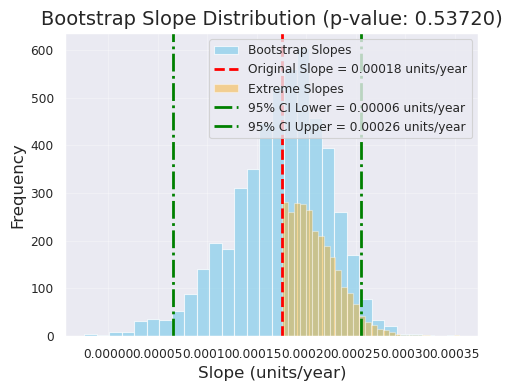

6.487981221147572e-05 0.00025588194126662694
 The trend for   ('OmegaA', 'T') is significant according to moving bootstrapping
OmegaAT
##################################


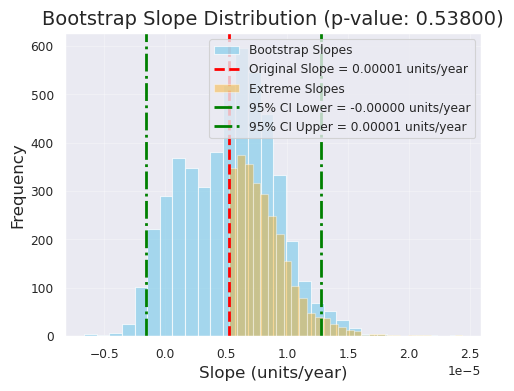

-1.5465355533884722e-06 1.2739548407680129e-05
OmegaAT
##################################


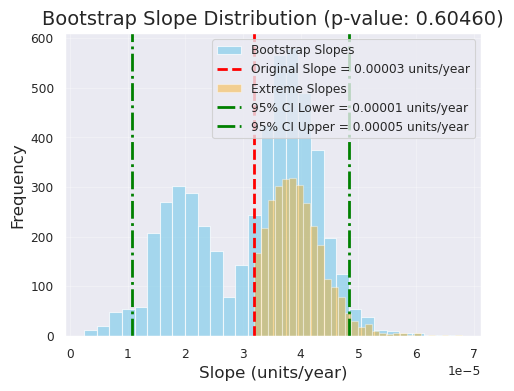

1.0796608518525126e-05 4.843750030502279e-05
 The trend for   ('OmegaA', 'T') is significant according to moving bootstrapping
OmegaAT
##################################


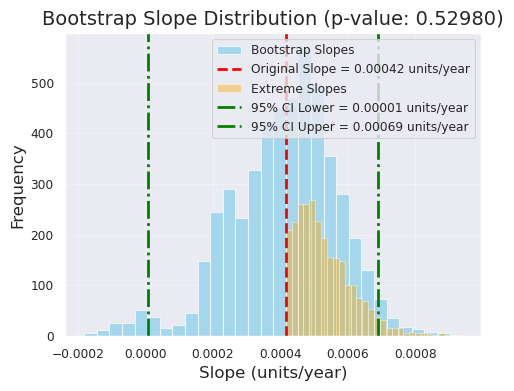

6.190468675350022e-06 0.0006903229260253678
 The trend for   ('OmegaA', 'T') is significant according to moving bootstrapping
OmegaAT
##################################


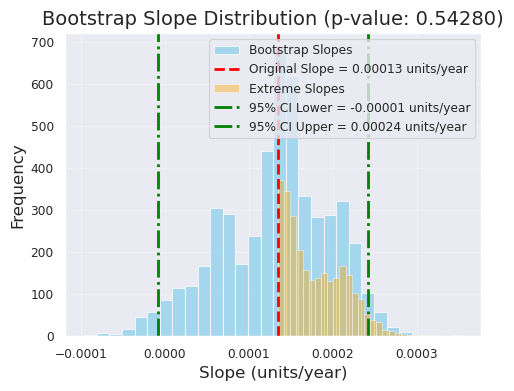

-8.125346788583038e-06 0.00024204652978261922


In [21]:
for cluster_id in np.arange(1,6):
    results=get_results_compound(cluster_id, results, 2)

TO2
##################################


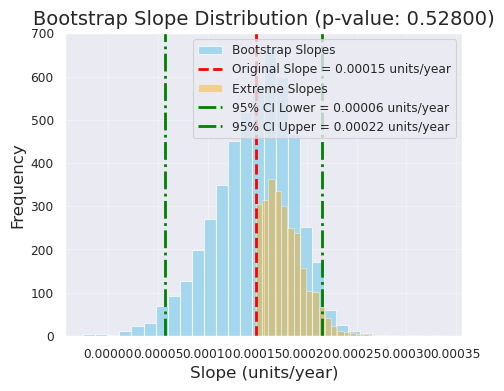

5.65691580458193e-05 0.00021535175473046862
 The trend for   ('T', 'O2', 'OmegaA') is significant according to moving bootstrapping
TO2
##################################


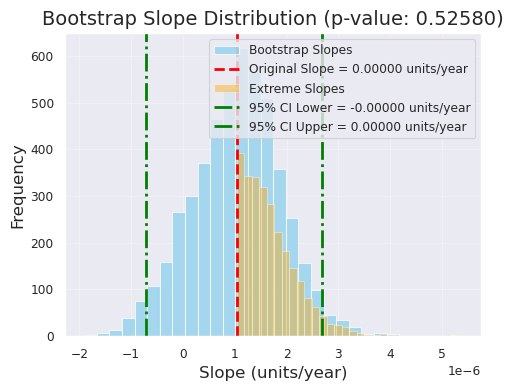

-7.149920770631974e-07 2.6806061532572774e-06
TO2
##################################


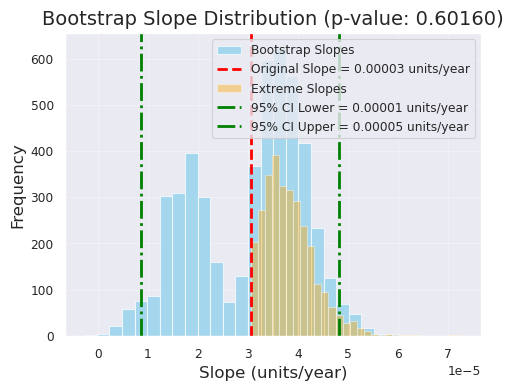

8.610159967294094e-06 4.816868596098622e-05
 The trend for   ('T', 'O2', 'OmegaA') is significant according to moving bootstrapping
TO2
##################################


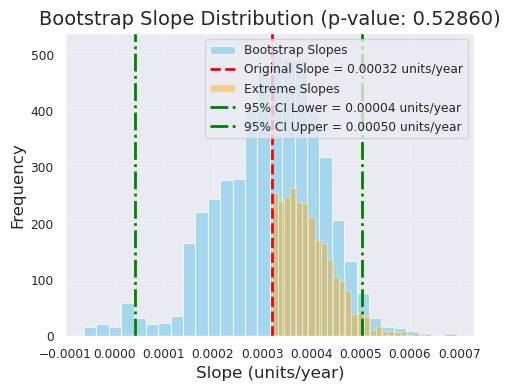

4.118157083881635e-05 0.0005032198692639714
 The trend for   ('T', 'O2', 'OmegaA') is significant according to moving bootstrapping
TO2
##################################


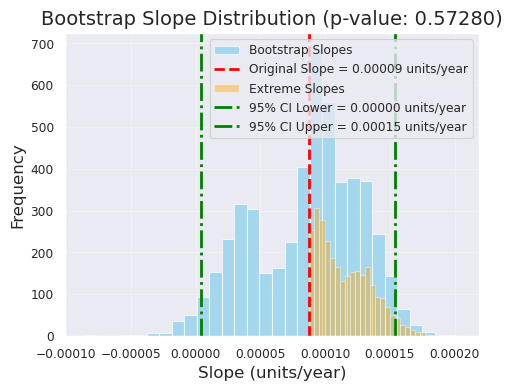

4.353022079321215e-06 0.00015408272577346476
 The trend for   ('T', 'O2', 'OmegaA') is significant according to moving bootstrapping


In [22]:
for cluster_id in np.arange(1,6):
    results=get_results_compound(cluster_id, results, 3)

In [24]:
results_df = pd.DataFrame(results)


In [25]:
significant_results = results_df[results_df["sig"]]


In [26]:
significant_results

,Cluster,Variable,Slope,P-Value,CI Lower,CI Upper,sig
3,3,O2,0.001448,0.5160,0.000489,0.002374,True
4,3,OmegaA,0.003922,0.4934,0.002230,0.006204,True
5,3,T,0.002207,0.4908,0.000281,0.004317,True
9,2,O2,-0.005081,0.4994,-0.007237,-0.003340,True
11,2,T,0.001591,0.5200,0.000114,0.002902,True
20,2,O2OmegaA,-0.001394,0.4982,-0.003120,-0.000311,True
21,3,O2OmegaA,0.001145,0.4954,0.000799,0.001472,True
25,1,O2T,0.000170,0.5546,0.000065,0.000254,True
27,3,O2T,0.000545,0.4902,0.000036,0.001110,True
28,4,O2T,0.000318,0.5288,0.000036,0.000506,True


In [ ]:
dual_extreme[2]

In [ ]:
dual_extreme[3]